In [110]:
#!pip install tensorflow==2.0.0-beta1 
import tensorflow as tf
import tensorflow.keras.layers
import cv2
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
from random import randint
import glob
import time
print(tf.__version__) #must be 2.0.0-beat1

2.0.0-beta1


In [2]:
"""
get dataset info (txt) and convert it to y_true = {'filename':[], 'classes':[], 'bboxes':[]}
"""
def get_bboxes(lines):
    lines = lines[8:]
    array=[]
    bboxes=[]
    for i in range(len(lines)):
        if i%5==2:
            array.append(lines[i].split(':')[1].split('-')) #bboxes=[['(xmin,ymin)','(xmax,ymax)'],[]]
    for i in range(len(array)):
        xmin,ymin = array[i][0][2:-2].split(',')
        xmax,ymax = array[i][1][2:-2].split(',')
        bboxes.append(int(xmin))
        bboxes.append(int(ymin))
        bboxes.append(int(xmax))
        bboxes.append(int(ymax))
    return bboxes
  
def get_classes(lines):
    line = lines[4]
    line = line.split('"')
    classes = []
    for i in range(len(line)):
        if i%2==1:
            classes.append(line[i])
    return classes

def txt_to_dict(file_path):
    file = open(file_path, 'r')
    classes = get_classes(file)
    bboxes = get_bboxes(file)

path = os.getcwd()+'/PennFudanPed/Annotation/'
files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
y_true = {'filepath':[],'classes':[], 'bboxes':[]}
for file in files:
    filepath = path + file
    f = open(filepath, 'r')
    lines = f.readlines()
    y_true['bboxes'].append(get_bboxes(lines))
    y_true['classes'].append(get_classes(lines))
    y_true['filepath'].append(filepath.replace('txt','png').replace('Annotation','PNGImages'))

y_true = pd.DataFrame.from_dict(y_true)
y_true.to_csv('YOLOv3_dataset.csv', index=False)

In [3]:
BBOXES_PER_CELL = 3
ANCHORS_SMALL = tf.constant([[10,13],[16,30],[33,23]], dtype=tf.float32)
ANCHORS_MEDIUM = tf.constant([[30,61],[62,45],[59,119]], dtype=tf.float32)
ANCHORS_LARGE = tf.constant([[116,90],[156,198],[373,326]], dtype=tf.float32)
INPUT_SIZE = 416
CLASSES_LIST =['PASpersonWalking', 'PASpersonStanding']
DISPLAY_CLASSES_LIST = ['walking', 'standing']
COLORS = [(randint(0,255), randint(0,255), randint(0,255)) for _ in range(len(CLASSES_LIST))]

In [72]:
def convolution(x, filters, kernel_size, strides=(1,1), padding='valid', activation='relu', use_bias=True):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides, padding='same')(x) #padding='same' so that convolution works out: (416-3)/2 + 1 -> 208 and not 207
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    return x

def residual_block(x, filters):
    shortcut = x
    x = convolution(x, filters, 1)
    x = convolution(x, filters, 1) #normally 3 but dimension problem
    x = tf.keras.layers.Add()([shortcut, x])
    x = tf.keras.layers.LeakyReLU()(x)
    return x
  
def darknet53(x):
    x = convolution(x, 32, 3) #(416-3)/1 + 1 = 414
    x = convolution(x, 64, 3, strides=(2,2)) #(414-3)/2 + 1 = 208 (we take the sup)
    x = residual_block(x, 64) #kernel = 1 so nothing changing -> 208
    x = convolution(x, 128, 3, strides=(2,2))#(208-3)/2 + 1 = 104
    for i in range(2):
        x = residual_block(x, 128)
    x = convolution(x, 256, 3, strides=(2,2)) #(104-3)/2 + 1 = 52
    for i in range(8):
        x = residual_block(x, 256)
    scale11 = x #52
    x = convolution(x, 512, 3, strides=(2,2)) #(52-3)/2 + 1 = 26
    for i in range(8):
        x = residual_block(x, 512)
    scale21 = x #26
    x = convolution(x, 1024, 3, strides=(2,2))
    for i in range(4):
        x = residual_block(x, 1024)
    scale22 = x
    scale3 = x
    for i in range(3):
        x = convolution(x, 512, 1)
        x = convolution(x, 1024, 3)
    
    scale3 = convolution(scale3, 255, 1)
    scale22 = convolution(scale22, 256, 1)
    scale22 = tf.keras.layers.UpSampling2D((2,2), interpolation='nearest')(scale22)
    scale2 = tf.keras.layers.Concatenate(axis=-1)([scale21,scale22])
    for i in range(3):
        scale2 = convolution(scale2, 256, 1)
        scale2 = convolution(scale2, 512, 3)
    scale12 = scale2
    scale2 = convolution(scale2, 255, 1)
    scale12 = convolution(scale12, 128, 1)
    scale12 = tf.keras.layers.UpSampling2D((2,2), interpolation='nearest')(scale12)
    scale1 = tf.keras.layers.Concatenate(axis=-1)([scale11, scale12])
    for i in range(3):
        scale1 = convolution(scale1, 128, 1)
        scale1 = convolution(scale1, 256, 3)
    scale1 = convolution(scale1, 255, 1)
    
    scale1 = convolution(scale1, 3*(5+len(CLASSES_LIST)), 1)
    scale2 = convolution(scale2, 3*(5+len(CLASSES_LIST)), 1)
    scale3 = convolution(scale3, 3*(5+len(CLASSES_LIST)), 1)
    return scale1, scale2, scale3

def tiny_darknet(x):
    return scale1, scale2, scale3
      
def decode(x, anchors):
    """
    input: scale1 or scale2 or scale3 (batch_size, S, S, 255)
    output: (batch_size*S*S*3, 5 + num_classes)
    """
    nb_cells = np.shape(x)[1]
    if nb_cells == None: #else error
        nb_cells = 0
    x = tf.reshape(x, (-1, 5 + len(CLASSES_LIST)))
    t_x, t_y, t_w, t_h = x[:, 0][:, tf.newaxis], x[:, 1][:, tf.newaxis], x[:, 2][:, tf.newaxis], x[:, 3][:, tf.newaxis]
    t_0 = x[:, 4][:, tf.newaxis]
    prob = x[:, 5:]
    
    tile_of_cells = np.array([np.unravel_index(i, (nb_cells, nb_cells)) for i in range(nb_cells**2)])
    rows = tile_of_cells[:,0]
    cols = tile_of_cells[:,1]
    rows = np.reshape(rows, (-1,1)) #convert to one column vector
    cols = np.reshape(cols, (-1,1))
    rows = np.repeat(rows, BBOXES_PER_CELL, axis=0) #repeat lines for each box
    cols = np.repeat(cols, BBOXES_PER_CELL, axis=0)
    #rows = c_y and cols = c_x
    
    b_x = tf.add(tf.sigmoid(t_x), cols)
    b_y = tf.add(tf.sigmoid(t_y), rows)
    anchors_repeat = np.repeat(anchors, nb_cells**2, axis=0) #to match the shape of tw
    b_w = tf.multiply(anchors_repeat[:,0][:, np.newaxis], tf.exp(t_w))
    b_h = tf.multiply(anchors_repeat[:,1][:, np.newaxis], tf.exp(t_h))
    t_0 = tf.sigmoid(t_0)
  
    return tf.concat([b_x, b_y, b_w, b_h, t_0, prob], -1)

def IOU(bp, bt):
    xminp, yminp, xmaxp, ymaxp = bp[:, 0], bp[:, 1], bp[:, 2], bp[:, 3]
    xmint, ymint, xmaxt, ymaxt = bt[:, 0], bt[:, 1], bt[:, 2], bt[:, 3]
    
    xminp, xmaxp = tf.minimum(xminp,xmaxp), tf.maximum(xminp,xmaxp)
    yminp, ymaxp = tf.minimum(yminp,ymaxp), tf.maximum(yminp,ymaxp)
    xmint, xmaxt = tf.minimum(xmint,xmaxt), tf.maximum(xmint,xmaxt)
    ymint, ymaxt = tf.minimum(ymint,ymaxt), tf.maximum(ymint,ymaxt)
    area_p = tf.multiply(tf.subtract(xmaxp,xminp), tf.subtract(ymaxp,yminp))
    area_t = tf.multiply(tf.subtract(xmaxt,xmint), tf.subtract(ymaxt,ymint))
    xI_1, xI_2, yI_1, yI_2 = tf.maximum(xminp, xmint), tf.minimum(xmaxp, xmaxt), tf.maximum(yminp, ymint), tf.minimum(ymaxp, ymaxt)
  
    cond = tf.logical_and(tf.greater(xI_2, xI_1), tf.greater(yI_2, yI_1))
    I = tf.multiply(tf.subtract(xI_2, xI_1), tf.subtract(yI_2, yI_1))
    true_mask = tf.constant(True, dtype=tf.bool, shape=np.shape(I.numpy()))
    zeros = tf.zeros(tf.shape(I), dtype=I.dtype)
    I = tf.where(cond, I, zeros)                
    
    U = tf.subtract(tf.add(area_p, area_t), I)
    return tf.divide(I,U)

def compute_loss(scale_true, scale_pred):
    """
    scale (13*13*3, 255) nparray
    returns scalar
    """
    nb_cells = np.shape(scale_true)[1]
    
    class_loss = 0 #classification loss
    loc_loss = 0 #localization loss
    conf_loss = 0 #confidence loss
    conf_loss_noobj = 0 #confidence loss if no object in cell
    
    lambda_coord = 5
    lambda_noobj = 0.5
    for i in range(nb_cells**2):
        for j in range(BBOXES_PER_CELL):
            obj_score_box = scale_true[:, BBOXES_PER_CELL*i + j, 4]
            x_ij_t, y_ij_t, w_ij_t, h_ij_t, conf_t = scale_true[:, BBOXES_PER_CELL*i + j, 0:5]
            x_ij_p, y_ij_p, w_ij_p, h_ij_p, conf_p = scale_pred[:, BBOXES_PER_CELL*i + j, 0:5]
            loc_loss += obj_score_box*(np.square(x_ij_t - x_ij_p) + np.square(y_ij_t - y_ij_p) + np.square(np.sqrt(w_ij_t)-np.sqrt(w_ij_p)) + np.square(np.sqrt(h_ij_t) - np.sqrt(h_ij_p)))
            conf_loss += obj_score_box*np.square(conf_t - conf_p)
            noobj_score_box = 1 - obj_score_box
            conf_loss_noobj = noobj_score_box*np.square(conf_t - conf_p)
            class_loss_inter = 0 #intermediary term
            for c in range(len(CLASSES_LIST)):
                class_loss_inter+= np.square(scale_true[:, BBOXES_PER_CELL*i + j, 5+c] - scale_pred[:, BBOXES_PER_CELL*i + j, 5+c])
            class_loss += obj_score_box*class_loss_inter
    loc_loss = lambda_coord*loc_loss   
    conf_loss_noobj = lambda_noobj*conf_loss_noobj
    
    return loc_loss + class_loss + conf_loss + conf_loss_noobj

def make_array(tensor):
    return np.fromiter(tensor, np.float)

def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.subtract(y_true, y_pred))

def loss(y_true, y_pred):
    """
    input: y_true = [scale1, scale2, scale3], y_pred = [scale1, scale2, scale3]
    #y_true = scale_true and y_pred = scale_pred
    """
    scale = np.shape(y_pred)[1]
    if scale==52:
        anchors = ANCHORS_SMALL
    elif scale==26:
        anchors = ANCHORS_MEDIUM
    elif scale==13:
        anchors = ANCHORS_LARGE
    
    #reshape to (batch_size*S*S*3, 255)
    y_true = tf.reshape(y_true, (-1, 5 + len(CLASSES_LIST)))
    y_pred = decode(y_pred, anchors)
    
    #(batch_size, S, S, 255)
    bx_pred = y_pred[:, 0][:, tf.newaxis]
    by_pred = y_pred[:, 1][:, tf.newaxis]
    bw_pred = y_pred[:, 2][:, tf.newaxis] 
    bh_pred = y_pred[:, 3][:, tf.newaxis]
    conf_pred = y_pred[:, 4][:, tf.newaxis] 
    probs_pred = y_pred[:, 5:]
                   
    bx_true = y_true[:, 0][:, tf.newaxis]
    by_true = y_true[:, 1][:, tf.newaxis]
    bw_true = y_true[:, 2][:, tf.newaxis] 
    bh_true = y_true[:, 3][:, tf.newaxis] 
    conf_true = y_true[:, 4][:, tf.newaxis]
    probs_true = y_true[:, 5:]
    
    term1 = tf.multiply(conf_true, tf.add(tf.square(tf.subtract(bx_true, bx_pred)), tf.square(tf.subtract(bx_true, bx_pred))))
    term1 = 5*tf.reduce_sum(term1)       
    
    term2 = tf.multiply(conf_true, tf.add(tf.square(tf.subtract(tf.sqrt(bw_true), tf.sqrt(bw_pred))), tf.square(tf.subtract(tf.sqrt(bh_true), tf.sqrt(bh_pred)))))
    term2 = 5*tf.reduce_sum(term2)
    
    term3 = tf.multiply(conf_true, tf.square(tf.subtract(conf_true, conf_pred)))
    term3 = tf.reduce_sum(term3)
    
    term4 = tf.multiply(1 - conf_true, tf.square(conf_true - conf_pred))
    term4 = 0.5*tf.reduce_sum(term4)
    
    term5 = tf.multiply(conf_true, tf.square(probs_true - probs_pred))
    term5 = tf.reduce_sum(term5)
                   
    return term1 + term2 + term3 + term4 + term5

In [107]:
#FOR TRAINING DATA AND DEMO
def image_preprocess(image, bboxes, target_size=(416,416)):
    """
    bboxes = [[xmin,ymin,xmax,ymax],[]] for one image
    resizes image and adds zero padding so that it is 416*416
    updates the bboxes (nparray) to match the new image
    returns the new image as nparray and y_true as a dict 'classes' and 'bboxes' (nparray)
    """
    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))
    

    image_paded = np.zeros((ih, iw, 3))
    dw, dh = (iw-nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized #the original image is centered
    image_paded = image_paded / 255.
    
    bboxes = np.array(bboxes)*scale + np.array([dw, dh, dw, dh]) #bboxes = [[xmin,ymin,xmax,ymax]]
    return image_paded, bboxes

def ground_truth_preprocess(classes, bboxes):
    """
    classes = [class1, class2], bboxes=[[xmin, ymin, xmax, ymax],[]] for ONE image
    returns 3 arrays of shape (N, N, 3, 5+num_classes) (one for each scale) scale = [[bx,by,bw,bh,conf,probs],[]]
    """
    scale1 = np.zeros((52, 52, BBOXES_PER_CELL, 5+len(CLASSES_LIST)))
    scale2 = np.zeros((26, 26, BBOXES_PER_CELL, 5+len(CLASSES_LIST)))
    scale3 = np.zeros((13, 13, BBOXES_PER_CELL, 5+len(CLASSES_LIST)))
    bboxes = np.array(bboxes)
    bboxes = np.reshape(bboxes, (-1,4)) #unspecified value -1
    for i,bbox in enumerate(bboxes):
        xmin, ymin, xmax, ymax = bbox
        center = np.array([xmin + xmax, ymin + ymax])*0.5
        width_height = np.array([xmax-xmin, ymax-ymin])
        #cell widths
        cell_w1, cell_w2, cell_w3 = INPUT_SIZE/52., INPUT_SIZE/26., INPUT_SIZE/13.
        #normalized center coordinates
        center1, center2, center3 = center/cell_w1, center/cell_w2, center/cell_w3
        #cells responsible for the ground truth
        cell_1, cell_2, cell_3 = (center1).astype(int), (center2).astype(int), (center3).astype(int)
        #confidence score
        scale1[cell_1[0], cell_1[1], :, 4] = 1.0 #b_x, b_y, b_w, b_h, C, probas
        scale2[cell_2[0], cell_2[1], :, 4] = 1.0
        scale3[cell_3[0], cell_3[1], :, 4] = 1.0
        #class probability
        num_class = CLASSES_LIST.index(classes[i])
        scale1[cell_1[0], cell_1[1], :, 5 + num_class] = 1.0
        scale2[cell_2[0], cell_2[1], :, 5 + num_class] = 1.0
        scale3[cell_3[0], cell_3[1], :, 5 + num_class] = 1.0
        #b_x, b_y
        scale1[cell_1[0], cell_1[1], :, 0:2] = center1-cell_1
        scale2[cell_2[0], cell_2[1], :, 0:2] = center2-cell_2
        scale3[cell_3[0], cell_3[1], :, 0:2] = center3-cell_3
        #b_w, b_h
        scale1[cell_1[0], cell_1[1], :, 2:4] = width_height/cell_w1
        scale2[cell_2[0], cell_2[1], :, 2:4] = width_height/cell_w2
        scale3[cell_3[0], cell_3[1], :, 2:4] = width_height/cell_w3
    return scale1, scale2, scale3

def bbox_back_to_scale(y):
    """
    input: y (13,13,3,255) tensor 
    convert [bx,by,bw,bh] to [xmin,ymin,xmax,ymax] 
    outputs a (N*N*3, 5+num_classes) vector
    """
    bboxes = y[:,:,:,:4]
    #convert to xmin, ymin, xmax, ymax and reshape to vector
    bx = np.reshape(bboxes[:,:,:,0], (-1,1))
    by = np.reshape(bboxes[:,:,:,1], (-1,1))
    bw = np.reshape(bboxes[:,:,:,2], (-1,1))
    bh = np.reshape(bboxes[:,:,:,3], (-1,1))
    #the bx and by are expressed in the referencial of the cell, we have to add (x_cell,y_cell)*dim_cell
    nb_cells = np.shape(bboxes)[0]
    tile_of_cells = np.array([np.unravel_index(i, (nb_cells, nb_cells)) for i in range(nb_cells**2)])
    rows = tile_of_cells[:,0]
    cols = tile_of_cells[:,1]
    rows = np.reshape(rows, (-1,1))
    cols = np.reshape(cols, (-1,1))
    rows = np.repeat(rows, BBOXES_PER_CELL, axis=0)
    cols = np.repeat(cols, BBOXES_PER_CELL, axis=0)
    bx = bx + rows
    #convert bx,by,bw,bh to xmin,ymin,xmax,ymax
    by = by + cols
    bboxes = np.array([bx-bw/2,by-bh/2,bx+bw/2,by+bh/2]).T[0] #transposing adds one dimension
    bboxes = bboxes*INPUT_SIZE/np.shape(y.numpy())[0]
    bboxes = bboxes.astype(int)
    y = tf.reshape(y, (-1,5+len(CLASSES_LIST)))
    y = tf.concat([bboxes,y[:,4:]],-1)
    return y

def non_max_suppression(y, iou_threshhold=0.5, obj_threshhold=0.6):
    """
    input: y=[[bx,by,bw,bh,conf,probas],[]] (13*13*3+26*26*3+52*52+*3, 5+num_classes)
    for the evaluation, not training (batch_size = 1 and shape(y)=(13,13,255))
    returns y as a (13*13*3 + 26*26*3 + 52*52+3, [xmin,xmax,ymin,ymax,class_id,class_prob]) tensor
    """
    #eliminate low objectness rows
    cond = tf.where(y[:,4]<=obj_threshhold, False, True)[:, tf.newaxis]
    cond = tf.tile(cond, [1,tf.shape(y)[1].numpy()]) #has to have the same number of columns as y
    y = tf.boolean_mask(y, cond) #returns a one row vector so we have to reshape it
    y = tf.reshape(y, (-1,5+len(CLASSES_LIST)))
    #assign the detection to the maximum probability
    bboxes = y[:,:4]
    conf = y[:, 4]
    probs = y[:, 5:]
    #iterate over the probs = [[p1,p2,...,pn],[p1,p2,...,pn],...]
    new_probs = []
    for i,prob in enumerate(probs):
        class_id = np.argmax(prob)
        new_probs+=[[class_id,prob[class_id]]]
    new_probs = np.array(new_probs[:])
    classes_id = np.unique(new_probs[:,0]).astype(int) #returns an array without repetition
    mask = tf.constant(True, dtype=tf.bool, shape=tf.shape(y)[0].numpy())[:, tf.newaxis]
    mask = tf.tile(mask, [1,tf.shape(y)[1].numpy()])
    for class_id in classes_id:
        class_confs = np.where(new_probs[:,0]==class_id, conf, 0.) #keeps the indexing of probs
        class_confs = tf.tile([class_confs], [np.shape(bboxes)[1],1])
        class_confs = tf.transpose(class_confs)
        indexes = [i for i in range(np.shape(class_confs)[0])]
        max_conf = np.argmax(class_confs, axis=0)[0] #get the index of the box with the highest confidence score
        while len(indexes)>0:#check all the boxes
            #print('indexes', indexes)
            pred = tf.tile([bboxes[max_conf]], [np.shape(bboxes)[0],1]) #create a vector with only bboxes[max_conf] to calculate IOU in one pass
            bboxes_filtered = np.where(class_confs==0.,tf.zeros(tf.shape(bboxes)),bboxes) #we make sure the iou for bboxes of other classes won't be > 0.5
            bboxes_filtered = tf.constant(bboxes_filtered) #convert to tensor
            iou = IOU(pred, bboxes_filtered)
            #print('iou', iou)
            iou = tf.where(tf.math.is_nan(iou), tf.ones_like(iou), iou) #check for nans
            new_mask = tf.where(iou>iou_threshhold, False, True)[:, tf.newaxis]
            new_mask = tf.tile(new_mask, [1, tf.shape(y)[1].numpy()])
            mask = tf.logical_and(mask, new_mask) #we update the mask to remove the bboxes for which iou > 0.5  
            mask = mask.numpy()
            mask_index = np.copy(mask[:,0]) #mask for the index
            mask[max_conf]=[True for _ in range(np.shape(mask)[1])] #since iou with itself = 1, the prediction was removed 
            for i,val in enumerate(mask_index):
                if not val and i in indexes: #maybe we already removed it
                    indexes.remove(i)
            if len(indexes)>0: #check if we didn't deleted it all in the previous steps
                max_conf = indexes[0] #and then iterate over all remaining boxes
    y = tf.boolean_mask(y, mask)
    mask = mask[:,:np.shape(new_probs)[1]] #to match shapes
    new_probs = tf.boolean_mask(new_probs, mask)
    new_probs = tf.reshape(new_probs, shape=(-1,2))
    y = tf.reshape(y, (-1,5+len(CLASSES_LIST)))
    new_probs = tf.cast(new_probs, y.dtype)
    y = tf.concat([y[:,:4],new_probs],1)
    return y

def bboxes_postprocess(y, org_img_shape):
    """
    y is a (N*N*3,255) tensor
    returns a (N*N*3,255) tensor
    """
    bboxes = y[:, :4]
    remainder = y[:, 4:]
    # convert to original aspect ratio
    org_h, org_w = org_img_shape
    resize_ratio = min(INPUT_SIZE/org_w, INPUT_SIZE/org_h)
    dw = (INPUT_SIZE - resize_ratio * org_w) / 2
    dh = (INPUT_SIZE - resize_ratio * org_h) / 2
    xmin = tf.divide(tf.subtract(bboxes[:, 0], dw), resize_ratio)
    xmax = tf.divide(tf.subtract(bboxes[:, 2], dw), resize_ratio)
    ymin = tf.divide(tf.subtract(bboxes[:, 1], dh), resize_ratio)
    ymax = tf.divide(tf.subtract(bboxes[:, 3], dh), resize_ratio)
    #clip boxes that are out of range
    xmin = tf.clip_by_value(xmin, 0, org_w)[:, tf.newaxis] #convert row to column vector
    xmax = tf.clip_by_value(xmax, 0, org_w)[:, tf.newaxis]
    ymin = tf.clip_by_value(ymin, 0, org_h)[:, tf.newaxis]
    ymax = tf.clip_by_value(ymax, 0, org_h)[:, tf.newaxis]
    
    return tf.concat([xmin, ymin, xmax, ymax, remainder], 1)

def draw_bboxes(bboxes, image):
    """
    bboxes = [[xmin,ymin,ymax,class_id,proba],[]]
    cv2 rectangle: top left, bottom right (y axis downwards)
    """
    h, w, _ = image.shape
    bbox_thick = int(0.6 * (h + w) / 200)
    for bbox in bboxes:
        xmin,ymin,xmax,ymax,class_id,score = bbox
        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), COLORS[class_id], bbox_thick)
        bbox_mess = '%s: %.2f' % (DISPLAY_CLASSES_LIST[class_id], score)
        t_size = cv2.getTextSize(bbox_mess, 0, 0.5, thickness=bbox_thick//2)[0]
        cv2.rectangle(image, (xmin,ymin), (xmin + t_size[0], ymin - t_size[1] - 3), COLORS[class_id], -1)
        cv2.putText(image, bbox_mess, (xmin, ymin-2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), bbox_thick//2, lineType=cv2.LINE_AA)
    return image

postprocess: 0.045 s


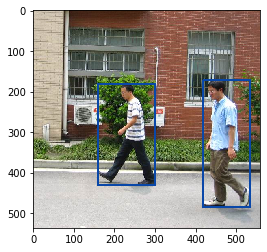

In [130]:
#EVAL ONE IMAGE
dataset = pd.read_csv('YOLOv3_dataset.csv', converters={"classes": lambda x: x.strip("[]").replace("'","").split(", "), "bboxes": lambda x: x.strip("[]").split(", ")})
i = 6
image_org = dataset['filepath'][i]
image_org = cv2.imread(image_org, 1)
image_org = cv2.cvtColor(image_org, cv2.COLOR_BGR2RGB)
img_shape = np.shape(image_org)[:2]
bboxes = dataset['bboxes'][i]
bboxes = np.array(bboxes).astype(int)
bboxes = np.reshape(bboxes, (-1,4))
classes = dataset['classes'][i]
y_true = {'classes':classes, 'bboxes':bboxes}
image, y_true['bboxes'] = image_preprocess(image_org, y_true['bboxes'])
scale1, scale2, scale3 = ground_truth_preprocess(y_true['classes'], y_true['bboxes'])
start_postprocess = time.time()
scale1 = tf.constant(scale1)
scale1 = bbox_back_to_scale(scale1)
scale2 = tf.constant(scale2)
scale2 = bbox_back_to_scale(scale2)
scale3 = tf.constant(scale3)
scale3 = bbox_back_to_scale(scale3)
y = tf.concat([scale1, scale2, scale3], 0)
y = non_max_suppression(y)
y = bboxes_postprocess(y, img_shape)
image = draw_bboxes(y, image_org)
plt.imshow(image);
stop_postprocess = time.time()
print('postprocess: {} s'.format(round(stop_postprocess - start_postprocess, 3)))

In [8]:
#TEST
test_train_ratio = 0.1
limit = int(test_train_ratio*len(dataset.index))

train_bboxes = []
train_classes = []
train_paths = []
test_bboxes = []  
test_classes = []
test_paths = []
for i in range(limit,len(dataset.index)):
    train_bboxes.append(np.reshape(np.array(dataset['bboxes'][i]).astype(int), (-1,4))) #convert bboxes to int and reshape it into a 4 columns vector
    train_classes.append(dataset['classes'][i])
    train_paths.append(dataset['filepath'][i])
for i in range(limit):
    test_bboxes.append(np.reshape(np.array(dataset['bboxes'][i]).astype(int), (-1,4)))
    test_classes.append(dataset['classes'][i])
    test_paths.append(dataset['filepath'][i])

train_images = []
train_scale1 = []
train_scale2 = []
train_scale3 = []
test_images = []
test_scale1 = []
test_scale2 = []
test_scale3 = []

for i in range(len(train_paths)):
    image = train_paths[i]
    image = cv2.imread(image, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image, bboxes = image_preprocess(image, train_bboxes[i])
    train_images.append(image)
    train_bboxes[i] = bboxes
    scale1, scale2, scale3 = ground_truth_preprocess(train_classes[i], train_bboxes[i])
    train_scale1.append(scale1)
    train_scale2.append(scale2)
    train_scale3.append(scale3)
    
for i in range(len(test_paths)):
    image = test_paths[i]
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image, bboxes = image_preprocess(image, test_bboxes[i])
    test_images.append(image)
    test_bboxes[i] = bboxes
    scale1, scale2, scale3 = ground_truth_preprocess(test_classes[i], test_bboxes[i])
    test_scale1.append(scale1)
    test_scale2.append(scale2)
    test_scale3.append(scale3)

train_images = tf.constant(train_images)
test_images = tf.constant(test_images)
train_scale1 = tf.constant(train_scale1)
train_scale2 = tf.constant(train_scale2)
train_scale3 = tf.constant(train_scale3)
test_scale1 = tf.constant(test_scale1)
test_scale2 = tf.constant(test_scale2)
test_scale3 = tf.constant(test_scale3)

In [10]:
checkpoint_path = "yolov3_coco.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # Save weights, every 5-epochs.
    period=5)

W0624 21:01:45.972901 4563965376 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [17]:
inputs = tf.keras.Input(shape=(INPUT_SIZE, INPUT_SIZE, 3))
scale1, scale2, scale3 = darknet53(inputs) # shape = (None, 52, 52, 255)
model = tf.keras.Model(inputs=inputs, outputs=[scale1, scale2, scale3])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=loss, #the function is applied for each output
              metrics=[loss])

model.summary()

Exception ignored in: <function _CheckpointRestoreCoordinator.__del__ at 0x130ba0b70>
Traceback (most recent call last):
  File "/anaconda3/envs/tf2.0/lib/python3.7/site-packages/tensorflow/python/training/tracking/util.py", line 244, in __del__
    .format(pretty_printer.node_names[node_id]))
  File "/anaconda3/envs/tf2.0/lib/python3.7/site-packages/tensorflow/python/training/tracking/util.py", line 93, in node_names
    path_to_root[node_id] + (child.local_name,))
  File "/anaconda3/envs/tf2.0/lib/python3.7/site-packages/tensorflow/python/training/tracking/object_identity.py", line 76, in __getitem__
    return self._storage[self._wrap_key(key)]
KeyError: (<tensorflow.python.training.tracking.object_identity._ObjectIdentityWrapper object at 0x15cd79cf8>,)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d_156 (Conv2D)             (None, 416, 416, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_156 (BatchN (None, 416, 416, 32) 128         conv2d_156[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_202 (LeakyReLU)     (None, 416, 416, 32) 0           batch_normalization_156[0][0]    
____________________________________________________________________________________________

In [28]:
# train
model.fit(train_images, [train_scale1, train_scale2, train_scale3],
                    batch_size=12,
                    epochs=5,
                    validation_split=0.2)

Train on 122 samples, validate on 31 samples
Epoch 1/5
122/122 [==============================] - 552s 5s/sample - loss: 133694.2000 - leaky_re_lu_199_loss: 67008.7812 - leaky_re_lu_200_loss: 24707.4609 - leaky_re_lu_201_loss: 41977.9727 - leaky_re_lu_199_loss_1: 67008.7812 - leaky_re_lu_200_loss_1: 24707.4609 - leaky_re_lu_201_loss_1: 41977.9727 - val_loss: 1883867073590.9387 - val_leaky_re_lu_199_loss: 46240.5352 - val_leaky_re_lu_200_loss: 1883810168832.0000 - val_leaky_re_lu_201_loss: 56458352.0000 - val_leaky_re_lu_199_loss_1: 46240.5352 - val_leaky_re_lu_200_loss_1: 1883810168832.0000 - val_leaky_re_lu_201_loss_1: 56458352.0000
Epoch 2/5
122/122 [==============================] - 434s 4s/sample - loss: 94781.4463 - leaky_re_lu_199_loss: 59050.5078 - leaky_re_lu_200_loss: 18451.6426 - leaky_re_lu_201_loss: 17279.2988 - leaky_re_lu_199_loss_1: 59050.5078 - leaky_re_lu_200_loss_1: 18451.6426 - leaky_re_lu_201_loss_1: 17279.2988 - val_loss: 72437.7067 - val_leaky_re_lu_199_loss: 4412

InvalidArgumentError:  Incompatible shapes: [8619,1] vs. [507,1]
	 [[node metrics_2/leaky_re_lu_201_loss_1/Mul_1 (defined at <ipython-input-28-39ac243f358a>:5) ]] [Op:__inference_keras_scratch_graph_95093]

Function call stack:
keras_scratch_graph


In [13]:
test_loss = model.evaluate(test_images, [test_scale1, test_scale2, test_scale3], verbose=2, batch_size = 1)
print('Test loss:', test_loss)

17/17 - 8s - loss: 86932.8426 - leaky_re_lu_199_loss: 53293.4453 - leaky_re_lu_200_loss: 14607.7314 - leaky_re_lu_201_loss: 19031.6719 - leaky_re_lu_199_loss_1: 53293.4453 - leaky_re_lu_200_loss_1: 14607.7314 - leaky_re_lu_201_loss_1: 19031.6719
Test loss: [86932.84260110294, 53293.445, 14607.731, 19031.672, 53293.445, 14607.731, 19031.672]


W0625 10:11:20.745156 4563965376 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


preprocess: 0.013 s
prediction: 0.384 s
post-process: 0.698 s
fps: 0.914


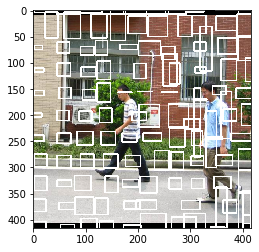

In [125]:
#prediction
start_preprocess = time.time()
i = 6
image = dataset['filepath'][i]
image = cv2.imread(image, 1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_shape = np.shape(image)[:2]
bboxes = dataset['bboxes'][i]
bboxes = np.array(bboxes).astype(int)
bboxes = np.reshape(bboxes, (-1,4))
image, _ = image_preprocess(image, bboxes)
image = tf.convert_to_tensor(image)
image = tf.reshape(image, (1, INPUT_SIZE, INPUT_SIZE, 3))

start_prediction = time.time()
scale1, scale2, scale3 = model.predict(image) # (1,52,52,21)
start_postprocess = time.time()
scale1 = tf.reshape(scale1, (np.shape(scale1)[1],np.shape(scale1)[2],BBOXES_PER_CELL, 5 + len(CLASSES_LIST)))
scale2 = tf.reshape(scale2, (np.shape(scale2)[1],np.shape(scale2)[2],BBOXES_PER_CELL, 5 + len(CLASSES_LIST)))
scale3 = tf.reshape(scale3, (np.shape(scale3)[1],np.shape(scale3)[2],BBOXES_PER_CELL, 5 + len(CLASSES_LIST)))
scale1 = bbox_back_to_scale(scale1) #[0] to eliminate the dimension due to batch size
scale2 = bbox_back_to_scale(scale2)
scale3 = bbox_back_to_scale(scale3)
y = tf.concat([scale1, scale2, scale3], 0)
y = non_max_suppression(y)
y = bboxes_postprocess(y, img_shape)
image = np.array(image[0])
image = draw_bboxes(y, image)
plt.imshow(image);
stop = time.time()
print('preprocess: {} s'.format(round(start_prediction - start_preprocess, 3)))
print('prediction: {} s'.format(round(start_postprocess - start_prediction, 3)))
print('post-process: {} s'.format(round(stop - start_postprocess, 3)))
print('fps: {}'.format(round(1/(stop - start_preprocess), 3)))

In [120]:
model.save('yolov3.h5')

In [ ]:
new_model = keras.models.load_model('yolov3.h5')
new_predictions = new_model.predict(x_test)
np.testing.assert_allclose(predictions, new_predictions, atol=1e-6)